In [1]:
import os
import parse
import pickle

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import dionysus as dion
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
import sklearn
import networkx as nx
from grakel import GraphKernel
import grakel
import seaborn as sns

from pt_activation.models.ccff_fashion import CCFF

%load_ext autoreload
%autoreload 2

In [2]:
def get_adv_info(filename):
    format_string = 'true-{}_adv-{}_sample-{}.npy'
    parsed = parse.parse(format_string, filename)
    return {'true class':int(parsed[0]), 'adv class':int(parsed[1]), 'sample':int(parsed[2])}

def read_adversaries(loc):
    ret = []
    for f in os.listdir(loc):
        if os.path.isfile(os.path.join(loc,f)) and f.find('.npy') != -1:
            adv = np.load(os.path.join(loc, f))
            info = get_adv_info(f)
            info['adversary'] = adv
            ret.append(info)
    return ret
    

In [3]:
adv_directory_loc = '/home/tgebhart/projects/pt_activation/logdir/adversaries/fashion/lbfgsm/ccff_fashion.pt/90'
adversaries = read_adversaries(adv_directory_loc)
adversaries = sorted(adversaries,  key=lambda k: k['sample'])

In [4]:
def create_filtrations(model, batch_size, up_to):
    device = torch.device("cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('../../fashion/data', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])), batch_size=batch_size, shuffle=False, **kwargs)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                row = {'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)

            t += batch_size
            if t >= up_to:
                break

    return pd.DataFrame(res_df)


def create_adversary_filtrations(model, batch_size, up_to, adversaries):
    device = torch.device("cpu")
    adv_images = torch.tensor(np.array([a['adversary'] for a in adversaries]))
    adv_labels = torch.tensor(np.array([a['true class'] for a in adversaries]))
    adv_samples = [a['sample'] for a in adversaries]
    
    print(adv_images.shape, adv_labels.shape)
    
    advs = torch.utils.data.TensorDataset(adv_images, adv_labels)
    test_loader = torch.utils.data.DataLoader(advs, batch_size=batch_size, shuffle=False)
    
    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    with torch.no_grad():
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                row = {'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0], 'sample':adv_samples[s+t]}
                res_df.append(row)

            t += (batch_size)
            if t >= up_to:
                break

    return pd.DataFrame(res_df)

def create_filtrations(model, batch_size, up_to):
    device = torch.device("cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('../../fashion/data', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])), batch_size=batch_size, shuffle=False, **kwargs)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                # check if this makes sense
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f = model.compute_dynamic_filtration(data[s], this_hiddens)
                #
                row = {'filtration':f, 'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)

            t += batch_size
            if t >= up_to:
                break

    return pd.DataFrame(res_df)


def create_adversary_filtrations(model, batch_size, up_to, adversaries):
    device = torch.device("cpu")
    adv_images = torch.tensor(np.array([a['adversary'] for a in adversaries]))
    adv_labels = torch.tensor(np.array([a['true class'] for a in adversaries]))
    
    print(adv_images.shape, adv_labels.shape)
    
    advs = torch.utils.data.TensorDataset(adv_images, adv_labels)
    test_loader = torch.utils.data.DataLoader(advs, batch_size=batch_size, shuffle=False)
    
    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    with torch.no_grad():
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                # check if this makes sense
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f = model.compute_dynamic_filtration(data[s], this_hiddens)
                #
                row = {'filtration':f, 'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)

            t += (batch_size)
            if t >= up_to:
                break

    return pd.DataFrame(res_df)

In [5]:
model_location = '/home/tgebhart/projects/pt_activation/logdir/models/ccff_fashion.pt'
model = CCFF()
model.load_state_dict(torch.load(model_location))

In [6]:
adv_df = create_adversary_filtrations(model, 50, 200, adversaries)

torch.Size([1003, 1, 28, 28]) torch.Size([1003])


In [7]:
res_df = create_filtrations(model, 50, 200)

In [8]:
def create_sample_graphs(df):
    sample_graphs = []
    for s in range(df.shape[0]):
        print(s)
        subgraphs = {}
        f = df['filtration'].iloc[s]
        m = dion.homology_persistence(f)
        dgms = dion.init_diagrams(m,f)
        for i,c in enumerate(m):
            if len(c) == 2:
                if f[c[0].index][0] in subgraphs:
                    subgraphs[f[c[0].index][0]].add_edge(f[c[0].index][0],f[c[1].index][0],weight=f[i].data)
                else:
                    eaten = False
                    for k, v in subgraphs.items():
                        if v.has_node(f[c[0].index][0]):
                            v.add_edge(f[c[0].index][0], f[c[1].index][0], weight=f[i].data)
                            eaten = True
                            break
                    if not eaten:
                        g = nx.Graph()
                        g.add_edge(f[c[0].index][0], f[c[1].index][0], weight=f[i].data)
                        subgraphs[f[c[0].index][0]] = g

        sample_graphs.append(subgraphs)
    return sample_graphs

In [9]:
# adv_sample_graphs = create_sample_graphs(adv_df)
# with open(os.path.join(adv_directory_loc, 'adv_samples.pkl'), 'wb') as f:
#     pickle.dump(adv_sample_graphs, f)
# sample_graphs = create_sample_graphs(res_df)
# with open(os.path.join(adv_directory_loc, 'samples.pkl'), 'wb') as f:
#     pickle.dump(sample_graphs, f)

sample_graphs = pickle.load( open(os.path.join(adv_directory_loc, 'samples.pkl'), "rb") )
adv_sample_graphs = pickle.load( open(os.path.join(adv_directory_loc, 'adv_samples.pkl'), "rb") )

In [10]:
# options = {
#     'node_color': 'red',
#     'node_size': 2,
#     'width': 3,
#     'with_labels':True}
# nx.draw_random(subgraphs[243], **options)

In [11]:
adv_df.head()

,class,loss,prediction,sample
0,9,-3.935201,5,0
1,2,13.750554,0,1
2,1,7.456456,3,2
3,1,4.386556,3,3
4,6,12.593495,0,4


In [12]:
res_df.head()

,class,loss,prediction
0,9,-4.110539,9
1,2,8.605694,2
2,1,7.452312,1
3,1,4.120848,1
4,6,8.420245,6


In [13]:
incorrects = res_df[res_df['class'] != res_df['prediction']]
corrects = res_df[res_df['class'] == res_df['prediction']]

In [14]:
incorrects.shape

(22, 3)

In [15]:
correct_list = list(corrects.index)
adv_correct_list = list(adv_df[~np.isin(adv_df['sample'], list(incorrects.index))].index)

In [16]:
sample_graphs = [sample_graphs[i] for i in correct_list]
adv_sample_graphs = [adv_sample_graphs[i] for i in adv_correct_list]

In [17]:
COLORS = ['#12355b', '#ff6978']
EDGE_COLOR = '#272d2d'
PLT_LABELS = ['Unaltered', 'Adversarial']
# COLORS = ['#bfdce7', '#ff6978']

In [18]:
sgl = np.zeros(len(sample_graphs))
for i in range(len(sample_graphs)):
    sgl[i] = len(sample_graphs[i])

adv_sgl = np.zeros(len(adv_sample_graphs))
for i in range(len(adv_sample_graphs)):
    adv_sgl[i] = len(adv_sample_graphs[i])


Text(0.5, 0, 'Number of Generators')

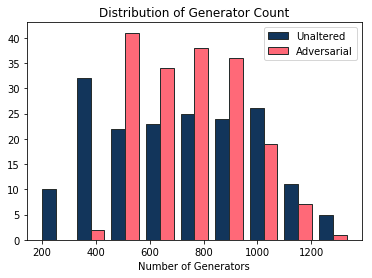

In [19]:
plt.hist([sgl, adv_sgl], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Generator Count')
plt.xlabel('Number of Generators')

take = 10
edges = set()
for i in range(len(sample_graphs)):
    for k in list(sample_graphs[i].keys())[:take]:
        for x in sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
            edges.add(edge_name)

for i in range(len(adv_sample_graphs)):
    for k in list(adv_sample_graphs[i].keys())[:take]:
        for x in adv_sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
            edges.add(edge_name)

edf = pd.DataFrame(np.zeros((len(sample_graphs)+len(adv_sample_graphs),len(edges))), columns=list(edges))
for i in range(len(sample_graphs)):
    print('Sample: {}/{}'.format(i,len(sample_graphs)))
    for k in list(sample_graphs[i].keys())[:take]:
        for x in sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
            edf.iloc[i][edge_name] = x[2]['weight']
            
for i in range(len(adv_sample_graphs)):
    print('Sample: {}/{}'.format(i,len(adv_sample_graphs)))
    for k in list(adv_sample_graphs[i].keys())[:take]:
        for x in adv_sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
            edf.iloc[i+len(sample_graphs)][edge_name] = x[2]['weight']

            

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
scaled = min_max_scaler.fit_transform(np.concatenate((sgl, adv_sgl), axis=0).reshape(-1,1))
edf['graph counts'] = pd.Series(scaled.T.reshape(-1), index=edf.index)

edf.tail()

X = edf.values[:len(sample_graphs)]
y = res_df['class'].values

clf = svm.SVC(gamma='scale', decision_function_shape='ovo').fit(X,y)

X_adv = edf.values[len(sample_graphs):]
adv_preds = clf.predict(X_adv)

sklearn.metrics.accuracy_score(adv_df['class'], adv_preds)

adv_preds[:10]

adv_df.head(10)

sklearn.metrics.accuracy_score(adv_df['prediction'], adv_preds)

clf2 = svm.SVC(gamma='scale', decision_function_shape='ovo').fit(X[:-100],y[:-100])

sklearn.metrics.accuracy_score(y[-100:], clf2.predict(X[-100:]))

In [20]:
all_gois = []
for i in range(len(sample_graphs)):
    print(i)
    a = [sample_graphs[i][k] for k in sample_graphs[i].keys()]
    all_gois.append(nx.compose_all(a))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177


In [21]:
adv_all_gois = []
for i in range(len(adv_sample_graphs)):
    print(i)
    a = [adv_sample_graphs[i][k] for k in adv_sample_graphs[i].keys()]
    adv_all_gois.append(nx.compose_all(a))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177


In [22]:
eigs = []
for i in range(len(all_gois)):
    print('normal ', i)
    eigs.append(nx.linalg.laplacian_spectrum(all_gois[i]))

adv_eigs = []
for i in range(len(adv_all_gois)):
    print('adv ', i)
    adv_eigs.append(nx.linalg.laplacian_spectrum(adv_all_gois[i]))

normal  0
normal  1
normal  2
normal  3
normal  4
normal  5
normal  6
normal  7
normal  8
normal  9
normal  10
normal  11
normal  12
normal  13
normal  14
normal  15
normal  16
normal  17
normal  18
normal  19
normal  20
normal  21
normal  22
normal  23
normal  24
normal  25
normal  26
normal  27
normal  28
normal  29
normal  30
normal  31
normal  32
normal  33
normal  34
normal  35
normal  36
normal  37
normal  38
normal  39
normal  40
normal  41
normal  42
normal  43
normal  44
normal  45
normal  46
normal  47
normal  48
normal  49
normal  50
normal  51
normal  52
normal  53
normal  54
normal  55
normal  56
normal  57
normal  58
normal  59
normal  60
normal  61
normal  62
normal  63
normal  64
normal  65
normal  66
normal  67
normal  68
normal  69
normal  70
normal  71
normal  72
normal  73
normal  74
normal  75
normal  76
normal  77
normal  78
normal  79
normal  80
normal  81
normal  82
normal  83
normal  84
normal  85
normal  86
normal  87
normal  88
normal  89
normal  90
normal  9

In [23]:
num_top_eigs = 800
top_eigs = np.zeros((len(eigs),num_top_eigs))
for i in range(len(eigs)):
#     top_eigs[i] = np.sort(eigs[i])[::-1][:num_top_eigs] # descending
    top_eigs[i] = np.sort(eigs[i])[:num_top_eigs] # ascending
    
adv_top_eigs = np.zeros((len(adv_eigs),num_top_eigs))
for i in range(len(adv_eigs)):
#     adv_top_eigs[i] = np.sort(adv_eigs[i])[::-1][:num_top_eigs] # descending
    adv_top_eigs[i] = np.sort(adv_eigs[i])[:num_top_eigs] # ascending

Text(0.5, 1.0, 'Distribution of Maximum Eigenvalue of Spectrum')

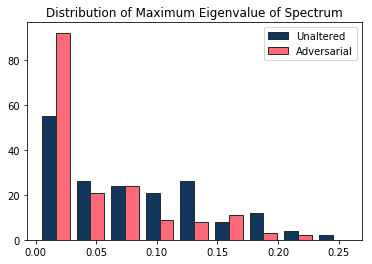

In [24]:
plt.hist([np.amax(top_eigs, axis=1),np.amax(adv_top_eigs, axis=1)], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Maximum Eigenvalue of Spectrum')

Text(0.5, 1.0, 'Distribution of Mean Eigenvalue of Spectrum')

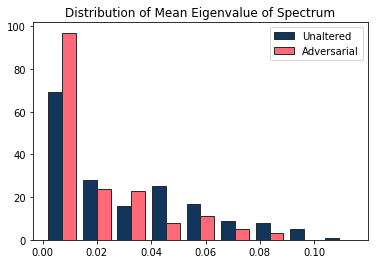

In [25]:
plt.hist([np.mean(top_eigs, axis=1),np.mean(adv_top_eigs, axis=1)], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Mean Eigenvalue of Spectrum')

Text(0.5, 1.0, 'Distribution of Median Eigenvalue of Spectrum')

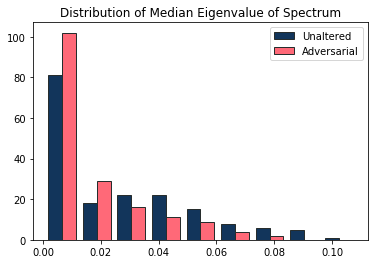

In [26]:
plt.hist([np.median(top_eigs, axis=1),np.median(adv_top_eigs, axis=1)], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Median Eigenvalue of Spectrum')

Text(0.5, 1.0, 'Distribution of Minimum Eigenvalue of Spectrum')

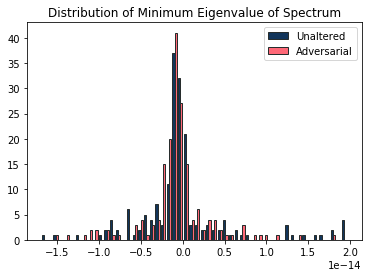

In [27]:
plt.hist([np.amin(top_eigs, axis=1),np.amin(adv_top_eigs, axis=1)], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Minimum Eigenvalue of Spectrum')

Text(0, 0.5, 'Probability')

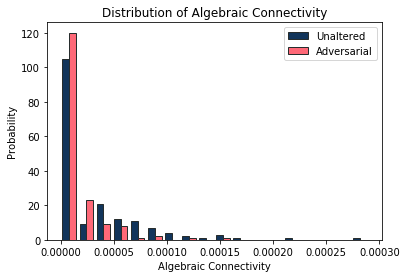

In [28]:
plt.hist([top_eigs[:,1], adv_top_eigs[:,1]], bins='auto',color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Algebraic Connectivity')
plt.xlabel('Algebraic Connectivity')
plt.ylabel('Probability')

In [29]:
mean_eigs = np.zeros((len(eigs),4))
for i in range(len(eigs)):
    mean_eigs[i] = [eigs[i].mean(), eigs[i].shape[0], np.median(eigs[i]), eigs[i][1]]
    
adv_mean_eigs = np.zeros((len(adv_eigs),4))
for i in range(len(adv_eigs)):
    adv_mean_eigs[i] = [adv_eigs[i].mean(), adv_eigs[i].shape[0], np.median(adv_eigs[i]), adv_eigs[i][1]]

Text(0.5, 1.0, 'Distribution of Mean Eigenvalues of Spectrum')

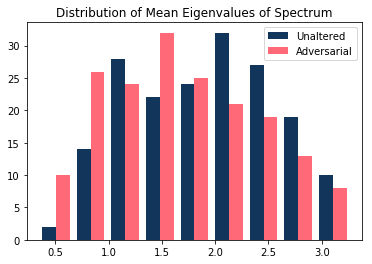

In [30]:
plt.hist([mean_eigs[:,0], adv_mean_eigs[:,0]], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Distribution of Mean Eigenvalues of Spectrum')

Text(0.5, 1.0, 'Distribution of Median Eigenvalues of Spectrum')

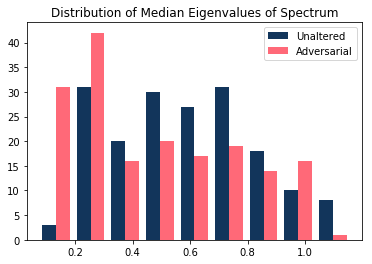

In [31]:
plt.hist([mean_eigs[:,2], adv_mean_eigs[:,2]], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Distribution of Median Eigenvalues of Spectrum')

Text(0.5, 1.0, 'Algebraic Connectivity')

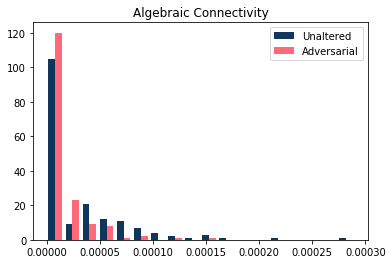

In [32]:
plt.hist([mean_eigs[:,3], adv_mean_eigs[:,3]], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Algebraic Connectivity')

Text(0.5, 1.0, 'Distribution of Spectrum Size')

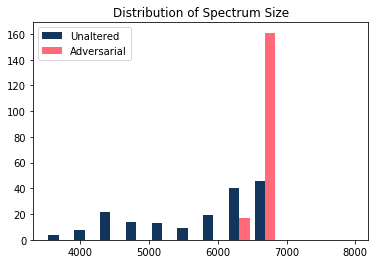

In [33]:
plt.hist([mean_eigs[:,1], adv_mean_eigs[:,1]], range=[3500, 8000], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Distribution of Spectrum Size')

In [34]:
some_num = 10
some_gois = []
for i in range(len(sample_graphs)):
    print(i)
    sgik = list(sample_graphs[i].keys())
    a = [sample_graphs[i][k] for k in sgik[len(sgik)-some_num:]]
    some_gois.append(nx.compose_all(a))
    
adv_some_gois = []
for i in range(len(adv_sample_graphs)):
    print(i)
    sgik = list(adv_sample_graphs[i].keys())
    a = [adv_sample_graphs[i][k] for k in sgik[len(sgik)-some_num:]]
    adv_some_gois.append(nx.compose_all(a))
    
some_eigs = []
for i in range(len(some_gois)):
    print('normal ', i)
    some_eigs.append(nx.linalg.laplacian_spectrum(some_gois[i]))

adv_some_eigs = []
for i in range(len(adv_some_gois)):
    print('adv ', i)
    adv_some_eigs.append(nx.linalg.laplacian_spectrum(adv_some_gois[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126


In [35]:
some_mean_eigs = np.zeros((len(some_eigs),5))
for i in range(len(some_eigs)):
    some_mean_eigs[i] = [some_eigs[i].mean(), some_eigs[i].shape[0], np.median(some_eigs[i]), some_eigs[i].min(), some_eigs[i].max()]
    
adv_some_mean_eigs = np.zeros((len(adv_some_eigs),5))
for i in range(len(adv_some_eigs)):
    adv_some_mean_eigs[i] = [adv_some_eigs[i].mean(), adv_some_eigs[i].shape[0], np.median(adv_some_eigs[i]), adv_some_eigs[i].min(), adv_some_eigs[i].max()]

Text(0.5, 1.0, 'Distribution of Mean Eigenvalues of Spectrum')

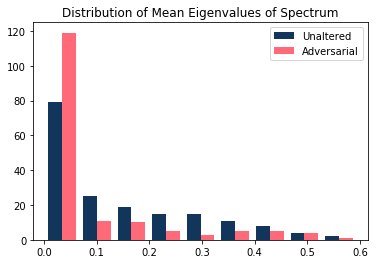

In [36]:
plt.hist([some_mean_eigs[:,0], adv_some_mean_eigs[:,0]], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Distribution of Mean Eigenvalues of Spectrum')

Text(0.5, 1.0, 'Distribution of Median Eigenvalues of Spectrum')

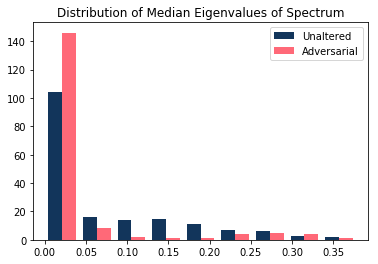

In [37]:
plt.hist([some_mean_eigs[:,2], adv_some_mean_eigs[:,2]], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Distribution of Median Eigenvalues of Spectrum')

Text(0.5, 1.0, 'Distribution of Spectrum Size')

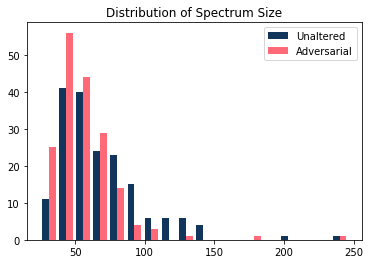

In [38]:
plt.hist([some_mean_eigs[:,1], adv_some_mean_eigs[:,1]], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Distribution of Spectrum Size')

Text(0.5, 1.0, 'Distribution of Minimum Eigenvalue of Spectrum')

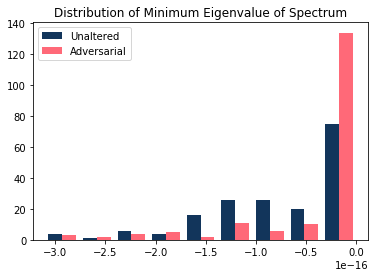

In [39]:
plt.hist([some_mean_eigs[:,3], adv_some_mean_eigs[:,3]], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Distribution of Minimum Eigenvalue of Spectrum')

Text(0.5, 1.0, 'Distribution of Maximum Eigenvalue of Spectrum')

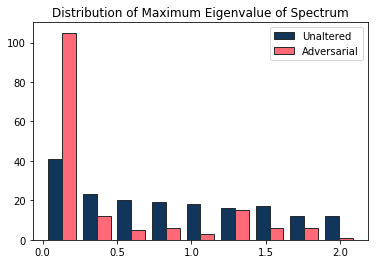

In [40]:
plt.hist([some_mean_eigs[:,4], adv_some_mean_eigs[:,4]], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Maximum Eigenvalue of Spectrum')

/home/tgebhart/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


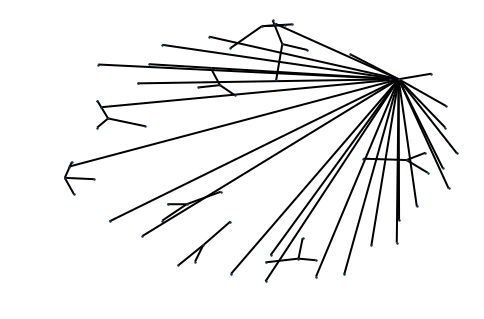

In [41]:
options = {
    'node_color': COLORS[0],
    'node_size': 2,
    'width': 2,
    'with_labels':False}
nx.draw_spring(some_gois[2], **options)

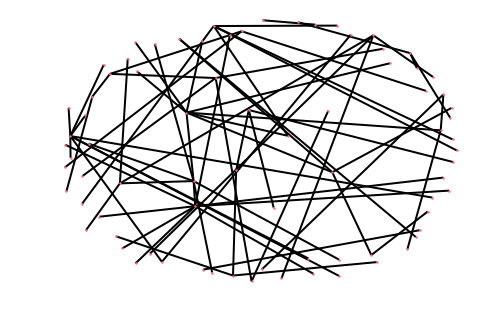

In [42]:
options = {
    'node_color': COLORS[1],
    'node_size': 2,
    'width': 2,
    'with_labels':False}
nx.draw_spring(adv_some_gois[2], **options)

In [43]:
some_num = 10
some_gois2 = []
for i in range(len(sample_graphs)):
    print(i)
    sgik = list(sample_graphs[i].keys())
    a = [sample_graphs[i][k] for k in sgik[:some_num]]
    some_gois2.append(nx.compose_all(a))
    
adv_some_gois2 = []
for i in range(len(adv_sample_graphs)):
    print(i)
    sgik = list(adv_sample_graphs[i].keys())
    a = [adv_sample_graphs[i][k] for k in sgik[:some_num]]
    adv_some_gois2.append(nx.compose_all(a))
    
some_eigs2 = []
for i in range(len(some_gois)):
    print('normal ', i)
    some_eigs2.append(nx.linalg.laplacian_spectrum(some_gois2[i]))

adv_some_eigs2 = []
for i in range(len(adv_some_gois)):
    print('adv ', i)
    adv_some_eigs2.append(nx.linalg.laplacian_spectrum(adv_some_gois2[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126


In [44]:
some_mean_eigs2 = np.zeros((len(some_eigs2),5))
for i in range(len(some_eigs)):
    some_mean_eigs2[i] = [some_eigs2[i].mean(), some_eigs2[i].shape[0], np.median(some_eigs2[i]), some_eigs2[i].min(), some_eigs2[i].max()]
    
adv_some_mean_eigs2 = np.zeros((len(adv_some_eigs2),5))
for i in range(len(adv_some_eigs2)):
    adv_some_mean_eigs2[i] = [adv_some_eigs2[i].mean(), adv_some_eigs2[i].shape[0], np.median(adv_some_eigs2[i]), adv_some_eigs2[i].min(), adv_some_eigs2[i].max()]

Text(0.5, 1.0, 'Distribution of Mean Eigenvalues of Spectrum')

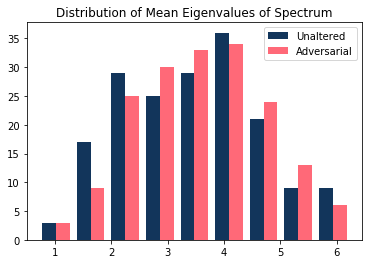

In [45]:
plt.hist([some_mean_eigs2[:,0], adv_some_mean_eigs2[:,0]], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Distribution of Mean Eigenvalues of Spectrum')

Text(0.5, 1.0, 'Distribution of Median Eigenvalues of Spectrum')

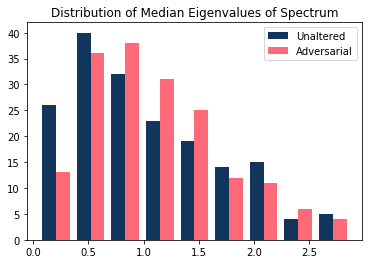

In [46]:
plt.hist([some_mean_eigs2[:,2], adv_some_mean_eigs2[:,2]], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Distribution of Median Eigenvalues of Spectrum')

Text(0.5, 1.0, 'Distribution of Spectrum Size')

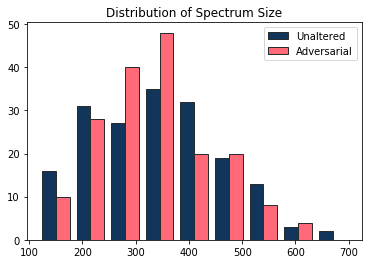

In [47]:
plt.hist([some_mean_eigs2[:,1], adv_some_mean_eigs2[:,1]], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Spectrum Size')

Text(0.5, 1.0, 'Distribution of Minimum Eigenvalue of Spectrum')

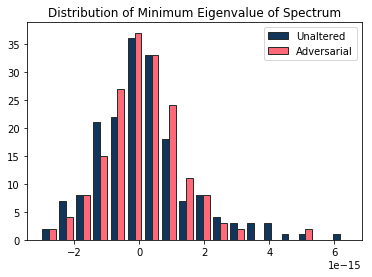

In [48]:
plt.hist([some_mean_eigs2[:,3], adv_some_mean_eigs2[:,3]], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Minimum Eigenvalue of Spectrum')

Text(0.5, 1.0, 'Distribution of Maximum Eigenvalue of Spectrum')

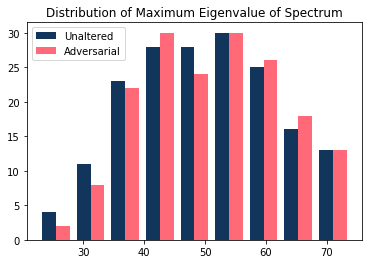

In [49]:
plt.hist([some_mean_eigs2[:,4], adv_some_mean_eigs2[:,4]], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Distribution of Maximum Eigenvalue of Spectrum')

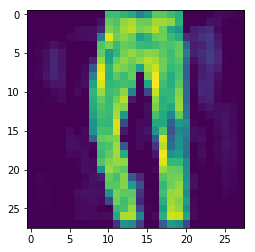

In [50]:
plt.imshow(adversaries[5]['adversary'].reshape(28,28))

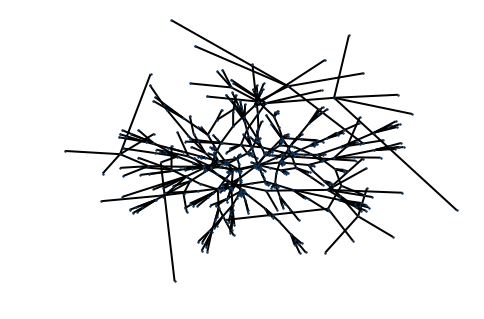

In [51]:
options = {
    'node_color': COLORS[0],
    'node_size': 2,
    'width': 2,
    'with_labels':False}
nx.draw_spring(some_gois2[2], **options)

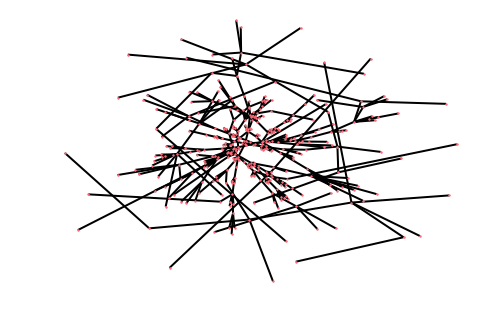

In [52]:
options = {
    'node_color': COLORS[1],
    'node_size': 2,
    'width': 2,
    'with_labels':False}
nx.draw_spring(adv_some_gois2[2], **options)

In [53]:
density = np.zeros(len(all_gois))
adv_density = np.zeros(len(adv_all_gois))
for i in range(len(all_gois)):
    density[i] = nx.classes.function.density(all_gois[i])
for i in range(len(adv_all_gois)):
    adv_density[i] = nx.classes.function.density(adv_all_gois[i])

Text(0.5, 1.0, 'Distribution of Graph Density')

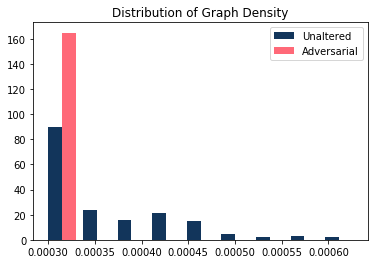

In [54]:
plt.hist([density, adv_density], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Distribution of Graph Density')